## Here we train the model sequentially on datasets 1, 2, 3

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
df = pd.read_csv('../../3OEC_current_flow.csv')

df["O2_avg"] = df[["O2_S1", "O2_S2", "O2_S3"]].mean(axis=1)

In [4]:
def MARE(prediction_tensor, truth_tensor):
    return torch.sum(torch.abs((prediction_tensor - truth_tensor)/truth_tensor))/truth_tensor.numel()

In [5]:
from datetime import datetime, timedelta

start_time_11 = datetime(2017, 7, 11, 14, 0, 0)
end_time_11 = datetime(2017, 7, 12, 8, 0, 0)

start_time_13 = datetime(2017, 7, 13, 11, 0, 0)
end_time_13 = datetime(2017, 7, 14, 6, 0, 0)

start_time_15 = datetime(2017, 7, 15, 10, 0, 0)
end_time_15 = datetime(2017, 7, 16, 6, 0, 0)

start_time_16 = datetime(2017, 7, 16, 16, 0, 0)
end_time_16 = datetime(2017, 7, 17, 6, 0, 0)

deployments = {
    "3oec_2017_7_11_12": {"start": start_time_11, "end": end_time_11},
    "3oec_2017_7_13_14": {"start": start_time_13, "end": end_time_13},
    "3oec_2017_7_15_16": {"start": start_time_15, "end": end_time_15},
    "3oec_2017_7_16_17": {"start": start_time_16, "end": end_time_16}
}

date_ranges = []

for deployment_name, deployment_info in deployments.items():
    start_time = deployment_info["start"]
    end_time = deployment_info["end"]
    if deployment_name == "3oec_2017_7_13_14":
        start_time -= timedelta(seconds=0.125)
    print(start_time)

    # Calculate total seconds and number of measurements
    total_seconds = (end_time - start_time).total_seconds() + 0.125
    num_measurements = int(total_seconds * 8)

    # Create DatetimeIndex for the deployment
    date_range = pd.date_range(start=start_time, periods=num_measurements, freq=f'{1000/8}ms')
    print(date_range[0], date_range[-1])
    print(len(date_range))
    date_ranges.append(pd.Series(date_range))

# Concatenate all DatetimeIndexes
complete_index = pd.concat(date_ranges)

# Set the complete index to your DataFrame
df.index = complete_index

2017-07-11 14:00:00
2017-07-11 14:00:00 2017-07-12 08:00:00
518401
2017-07-13 10:59:59.875000
2017-07-13 10:59:59.875000 2017-07-14 06:00:00
547202
2017-07-15 10:00:00
2017-07-15 10:00:00 2017-07-16 06:00:00
576001
2017-07-16 16:00:00
2017-07-16 16:00:00 2017-07-17 06:00:00
403201


In [6]:
# drop deployment column and resample
df_resampled = df.drop(columns=['deployment', 't', 't_increase', 'Vx', 'Vy', 'Vz', 'P', 'O2_S1', 'O2_S2', 'O2_S3']).resample('5min').mean()

In [7]:
first_piece = df_resampled["2017-07-11":"2017-07-12 06:00:00"]
second_piece = df_resampled["2017-07-13 12:00:00":"2017-07-14 06:00:00"]
third_piece = df_resampled["2017-07-15 12:00:00":"2017-07-16 6:00:00"]
fourth_piece = df_resampled["2017-07-16 16:00:00":"2017-07-17"]

In [8]:
def create_sequences(data, seq_length):
    """
    Creates sequences and their corresponding target sequences from the input data.
    The target sequence is half the size of the training sequence.

    Args:
        data (array-like): The input data.
        seq_length (int): The length of each training sequence.

    Returns:
        np.ndarray: Array of input sequences.
        np.ndarray: Array of target sequences (half the length of input sequences).
    """

    sequences = []
    targets = []
    
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])                        # Input sequence
        targets.append(data[i+seq_length]) # Target is a single step

    return np.array(sequences), np.array(targets)


In [9]:
# data piece 1

column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(first_piece)
train_df1 =first_piece[:int(n*0.8)]
val_df1 = first_piece[int(n*0.8):]
# test_df1 = first_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean1 = train_df1.mean()
train_std1 = train_df1.std()

train_df1 = (train_df1 - train_mean1) / train_std1
val_df1 = (val_df1 - train_mean1) / train_std1

# make sequences
train_seq1, train_labels1 = create_sequences(train_df1.values, 12)
val_seq1, val_labels1 = create_sequences(val_df1.values, 12)

# make tensors
train_seq_tensor1 = torch.FloatTensor(train_seq1).to(device='cuda')  # (batch, seq_length, input_dim)
train_label_tensor1 = torch.FloatTensor(train_labels1).to(device='cuda') # (batch, output_dim)
val_seq_tensor1 = torch.FloatTensor(val_seq1).to(device='cuda')  # (batch, seq_length, input_dim)
val_label_tensor1 = torch.FloatTensor(val_labels1).to(device='cuda')  # (batch, output_dim)

# Data piece 2

column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(second_piece)
train_df2 =second_piece[0:int(n*0.8)]
val_df2 = second_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean2 = train_df2.mean()
train_std2 = train_df2.std()

train_df2 = (train_df2 - train_mean2) / train_std2
val_df2 = (val_df2 - train_mean2) / train_std2

# make sequences
train_seq2, train_labels2 = create_sequences(train_df2.values, 12)
val_seq2, val_labels2 = create_sequences(val_df2.values, 12)

# make tensors
train_seq_tensor2 = torch.FloatTensor(train_seq2).to(device='cuda')  # (batch, seq_length, input_dim)
train_label_tensor2 = torch.FloatTensor(train_labels2).to(device='cuda') # (batch, output_dim)
val_seq_tensor2 = torch.FloatTensor(val_seq2).to(device='cuda')  # (batch, seq_length, input_dim)
val_label_tensor2 = torch.FloatTensor(val_labels2).to(device='cuda')  # (batch, output_dim)

# Data piece 3

column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(third_piece)
train_df3 =third_piece[0:int(n*0.8)]
val_df3 = third_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean3 = train_df3.mean()
train_std3 = train_df3.std()

train_df3 = (train_df3 - train_mean3) / train_std3
val_df3 = (val_df3 - train_mean3) / train_std3

# make sequences
train_seq3, train_labels3 = create_sequences(train_df3.values, 12)
val_seq3, val_labels3 = create_sequences(val_df3.values, 12)

# make tensors
train_seq_tensor3 = torch.FloatTensor(train_seq3).to(device='cuda')  # (batch, seq_length, input_dim)
train_label_tensor3 = torch.FloatTensor(train_labels3).to(device='cuda') # (batch, output_dim)
val_seq_tensor3 = torch.FloatTensor(val_seq3).to(device='cuda')  # (batch, seq_length, input_dim)
val_label_tensor3 = torch.FloatTensor(val_labels3).to(device='cuda')  # (batch, output_dim)

In [10]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # self.do = nn.Dropout()
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)  # Initial hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)  # Initial cell state
        
        out, _ = self.lstm(x, (h0, c0))
        # out = self.do(out)
        out = self.fc(out[:, -1, :])  # Take the last 30 time step output
        return out

# Model parameters
input_dim = 1
hidden_dim = 256
num_layers = 3
output_dim = 1

In [11]:
model123 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model123 = model123.to("cuda")  # Use "cuda" if you have a GPU

# model2 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
# model2 = model2.to("cuda")  # Use "cuda" if you have a GPU

# model3 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
# model3 = model3.to("cuda")  # Use "cuda" if you have a GPU

criterion123 = nn.SmoothL1Loss()
optimizer123 = optim.Adam(model123.parameters(), lr=1e-4)

### Train on partitions 1, 2, 3

In [12]:
num_epochs = 200

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model123.train()
    optimizer123.zero_grad()
    y_pred = model123(train_seq_tensor1)
    loss = criterion123(y_pred, train_label_tensor1)
    train_losses.append(loss.item())

    loss.backward()
    optimizer123.step()

    # Validation
    model123.eval()
    with torch.no_grad():
        y_val = model123(val_seq_tensor1)
    val_loss = criterion123(y_val, val_label_tensor1)
    val_losses.append(val_loss.item())

    if epoch % 10 == 0:
        print(f'Epoch: {epoch}. Train loss: {loss.item()}. Val loss: {val_loss.item()}')

Epoch: 0. Train loss: 0.4373045265674591. Val loss: 1.2864186763763428
Epoch: 10. Train loss: 0.4273359775543213. Val loss: 1.2632087469100952
Epoch: 20. Train loss: 0.405590683221817. Val loss: 1.1803985834121704
Epoch: 30. Train loss: 0.34064552187919617. Val loss: 0.9051237106323242
Epoch: 40. Train loss: 0.18886056542396545. Val loss: 0.1127818152308464
Epoch: 50. Train loss: 0.16999167203903198. Val loss: 0.024684829637408257
Epoch: 60. Train loss: 0.15550895035266876. Val loss: 0.011946063488721848
Epoch: 70. Train loss: 0.14693932235240936. Val loss: 0.052316419780254364
Epoch: 80. Train loss: 0.1386595070362091. Val loss: 0.03496196120977402
Epoch: 90. Train loss: 0.1299627423286438. Val loss: 0.011191115714609623
Epoch: 100. Train loss: 0.119964599609375. Val loss: 0.015816757455468178
Epoch: 110. Train loss: 0.10786054283380508. Val loss: 0.016864465549588203
Epoch: 120. Train loss: 0.09269867092370987. Val loss: 0.022892214357852936
Epoch: 130. Train loss: 0.0726628378033638

In [13]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model123.train()
    optimizer123.zero_grad()
    y_pred = model123(train_seq_tensor2)
    loss = criterion123(y_pred, train_label_tensor2)
    train_losses.append(loss.item())
    
    loss.backward()
    optimizer123.step()

    # Validation
    model123.eval()
    with torch.no_grad():
        y_val = model123(val_seq_tensor2)

    val_loss = criterion123(y_val, val_label_tensor2)
    val_losses.append(val_loss.item())

    if epoch % 10 == 0:
        print(f'Epoch: {epoch}. Train loss: {loss.item()}. Val loss: {val_loss.item()}')

Epoch: 0. Train loss: 0.032902494072914124. Val loss: 0.012537838891148567
Epoch: 10. Train loss: 0.025337163358926773. Val loss: 0.039477407932281494
Epoch: 20. Train loss: 0.022663749754428864. Val loss: 0.026444129645824432
Epoch: 30. Train loss: 0.02109455317258835. Val loss: 0.028437955304980278
Epoch: 40. Train loss: 0.019673693925142288. Val loss: 0.03812287747859955
Epoch: 50. Train loss: 0.018389612436294556. Val loss: 0.030650516971945763
Epoch: 60. Train loss: 0.01713729463517666. Val loss: 0.027149520814418793
Epoch: 70. Train loss: 0.015965446829795837. Val loss: 0.024748124182224274
Epoch: 80. Train loss: 0.015011537820100784. Val loss: 0.016378574073314667
Epoch: 90. Train loss: 0.015582889318466187. Val loss: 0.02221313677728176
Epoch: 100. Train loss: 0.013957696035504341. Val loss: 0.013786492869257927
Epoch: 110. Train loss: 0.013780237175524235. Val loss: 0.016477104276418686
Epoch: 120. Train loss: 0.013343687169253826. Val loss: 0.015979744493961334
Epoch: 130. Tr

In [14]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model123.train()
    optimizer123.zero_grad()
    y_pred = model123(train_seq_tensor3)
    loss = criterion123(y_pred, train_label_tensor3)
    train_losses.append(loss.item())
    
    loss.backward()
    optimizer123.step()

    # Validation
    model123.eval()
    with torch.no_grad():
        y_val = model123(val_seq_tensor3)

    val_loss = criterion123(y_val, val_label_tensor3)
    val_losses.append(val_loss.item())

    if epoch % 10 == 0:
        print(f'Epoch: {epoch}. Train loss: {loss.item()}. Val loss: {val_loss.item()}')

Epoch: 0. Train loss: 0.01869579218327999. Val loss: 0.008156497031450272
Epoch: 10. Train loss: 0.01712040975689888. Val loss: 0.007516925688832998
Epoch: 20. Train loss: 0.016286885365843773. Val loss: 0.007963950745761395
Epoch: 30. Train loss: 0.015213255770504475. Val loss: 0.007794841658324003
Epoch: 40. Train loss: 0.01511693187057972. Val loss: 0.014449408277869225
Epoch: 50. Train loss: 0.01472135353833437. Val loss: 0.010580942966043949
Epoch: 60. Train loss: 0.013082930818200111. Val loss: 0.007256744895130396
Epoch: 70. Train loss: 0.012123827822506428. Val loss: 0.008787903934717178
Epoch: 80. Train loss: 0.011394573375582695. Val loss: 0.008431434631347656
Epoch: 90. Train loss: 0.01137266680598259. Val loss: 0.006193776614964008
Epoch: 100. Train loss: 0.010303303599357605. Val loss: 0.006264409050345421
Epoch: 110. Train loss: 0.010158974677324295. Val loss: 0.007900651544332504
Epoch: 120. Train loss: 0.009904438629746437. Val loss: 0.0075516472570598125
Epoch: 130. Tr

### Now let's predict dataset 4

In [15]:
test_data = (fourth_piece[:] - fourth_piece.mean())/fourth_piece.std() 
test_seq, test_labels = create_sequences(test_data.values, 12)

test_seq_tensor = torch.FloatTensor(test_seq).to(device='cuda')
test_label_tensor = torch.FloatTensor(test_labels).to(device='cuda')

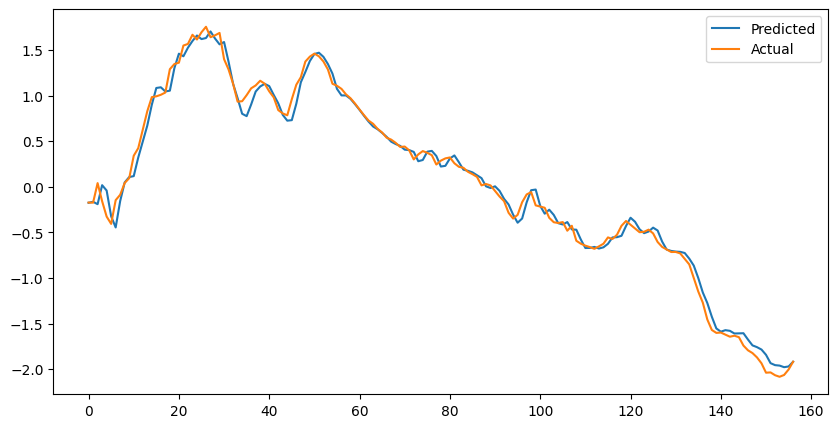

In [16]:
with torch.no_grad():
    y_pred = model123(test_seq_tensor)

plt.figure(figsize=(10,5))
plt.plot(y_pred.cpu().numpy(), label='Predicted')
plt.plot(test_label_tensor.cpu().numpy(), label='Actual')
plt.legend()
plt.show()

[]

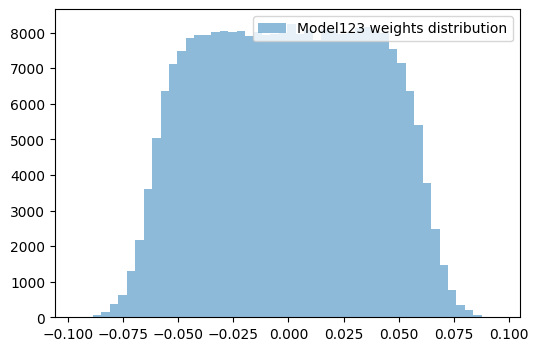

In [17]:
sd123 = model123.state_dict()
w123 = sd123["lstm.weight_hh_l1"].reshape(-1).cpu().numpy()
plt.figure(figsize=(6, 4))
plt.hist(w123, 50, alpha=0.5, label='Model123 weights distribution')
plt.legend()
plt.plot()